In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import re

BASE_SEED = 5142024
rng = np.random.default_rng(BASE_SEED)

# Floating point safe vectorized comparison function
W = lambda T_pi1, T_pi2: (~np.isclose(T_pi1, T_pi2) & (T_pi1 > T_pi2)) + 0.5 * np.isclose(T_pi1, T_pi2)

########################################################
# Read in the data and process it into a usable form
########################################################

raw_df = pd.read_csv("./MY-LC-Data/41586_2023_6651_MOESM4_ESM.csv")

df = raw_df.copy()
df = df[df["x0_Censor_Complete"] == 0] # Remove censored patients
df["LC"] = (df["x0_Censor_Cohort_ID"] == 3).astype(np.float32) # Retrieve Long Covid Status

# Select and rename the features of interest
cell_features_names = list(filter(lambda x: re.search(r"Flow_Cyt_.*ML$", x), df.columns))
other_features = [
    "LC",
    "x0_Demographics_Age",
    "x0_Demographics_Sex",
    "x0_Demographics_BMI",
]
all_features = other_features + cell_features_names

def feature_renaming(name):
    parts = name.split("_")
    if (len(parts) == 1):
        return(parts[0])
    elif (len(parts) == 3):
        return(parts[2])
    else:
        return(parts[3])
df = df[all_features].rename(feature_renaming, axis = "columns")

cell_features_names = list(map(feature_renaming, cell_features_names))
demo_features_names = list(map(feature_renaming, other_features[1:]))

# Create the design matrix
df = df.dropna(subset = ["Age", "Sex", "BMI"]) # First drop any rows that have missing demographics

df["Sex"] = df["Sex"] - 1 # Convert Sex to {0, 1} rather than {1, 2}
df["Age*BMI"] = df["Age"] * df["BMI"]
df["Sex*BMI"] = df["Sex"] * df["BMI"]

# Do not standardize X
X_unfiltered = df[["LC"]].to_numpy()

# Standardize Z
Z_unfiltered = df[["Age", "Sex", "BMI", "Age*BMI", "Sex*BMI"]].to_numpy()
Z_unfiltered = (Z_unfiltered - Z_unfiltered.mean(axis = 0)) / Z_unfiltered.std(axis = 0)
Z_unfiltered = np.concatenate([np.ones((Z_unfiltered.shape[0], 1)), Z_unfiltered], axis = 1)

feature_names_dict = {}
feature_names_dict["DC1ofLive"] = "cDC1"
feature_names_dict["ncMonoofLive"] = "Nonclassical monocytes"
feature_names_dict["cMonoofLive"] = "Classical monocytes"
feature_names_dict["TotalNeutofLive"] = "Total neutrophils"
feature_names_dict["CD16hiNeutofLive"] = "CD16hi neutrophils"
feature_names_dict["CD16intNeutofLive"] = "CD16int neutrophils"
feature_names_dict["CD8TofCD3"] = "T cell(cytotoxic)"
feature_names_dict["NaiveCD8TofCD8"] = "CD8+ T(naive)"
feature_names_dict["FollCD8ofCD8"] = "CD8+ T cell(follicular)"
feature_names_dict["CD8TexofCD8"] = "CD8+ T cell(exhuasted)"
feature_names_dict["CD8TCRactofCD8"] = "CD8+ T cell(activated TCR)"
feature_names_dict["PD1pCD8TemraofCD8"] = "CD8+ T cell(PD1+Temr)"
feature_names_dict["CD8TemofCD8"] = "CD8+ T cell(Tem)"
feature_names_dict["CD8PD1pTcmofCD8"] = "CD8+ T cell(PD1+Tcm)"
feature_names_dict["CD8PD1pAAofCD8"] = "CD8+ T cell(PD1+AA)"
feature_names_dict["CD8TemraofCD8"] = "CD8+ T cell(Temra)"
feature_names_dict["CD4PD1pTcmofCD4"] = "CD4+ T cell(PD1+Tcm)"
feature_names_dict["CD4IL4pofCD4"] = "CD4+ T cell(IL4+)"
feature_names_dict["CD4TcmofCD4"] = "CD4+ T cell(Tcm)"
feature_names_dict["CD4TemofCD4"] = "CD4+ T cell(Tem)"
feature_names_dict["CD4TexofCD4"] = "CD4+ T cell(exhuasted)"
feature_names_dict["CD4PD1pAAofCD4"] = "CD4+ T cell(PD1+AA)"
feature_names_dict["CD4TofCD3"] = "T cell(helper)"
feature_names_dict["CD4TCRactofCD4"] = "CD4+ T cell(activated TCR)"
feature_names_dict["CD8CXCR3pofCD8"] = "CD8+ T cell(CXCR3+)"
feature_names_dict["CD8GranzymeBpofCD8"] = "CD8+ T cell(GranzymeB+)"
feature_names_dict["CD8TNFapofCD8"] = "CD8+ T cell(TNFa+)"
feature_names_dict["CD8IFNypofCD8"] = "CD8+ T cell(IFNy+)"
feature_names_dict["CD4CXCR3pofCD4"] = "CD4+ T cell(CXCR3+)"
feature_names_dict["CD4IL17pofCD4"] = "CD4+ T cell(IL17+)"
feature_names_dict["CD4TNFapofCD4"] = "CD4+ T cell(TNFa+)"
feature_names_dict["CD4IFNypofCD4"] = "CD4+ T cell(IFNy+)"
feature_names_dict["CD8IL2ofCD8"] = "CD8+ T cell(IL2+)"
feature_names_dict["CD8IL6ofCD8"] = "CD8+ T cell(IL6+)"
feature_names_dict["IL4IL6DPofCD4"] = "CD4+ T cell(IL4+IL6+)"
feature_names_dict["CD86HLADRBofB"] = "B cell(activated)"
feature_names_dict["ASCofB"] = "B cell(antibody-secreting/plasma)"
feature_names_dict["USMemofB"] = "B cell(memory)"
feature_names_dict["CSMemofB"] = "B cell(memory)"
feature_names_dict["NaiveBofB"] = "B cell(naive)"
feature_names_dict["DNofB"] = "B cell(double negative)"
feature_names_dict["IL4IL6DPofCD8"] = "CD8+ T cell(IL4+IL6+)"
feature_names_dict["IL4ofCD8"] = "CD8+ T cell (IL4+)"
feature_names_dict["DC2ofLive"] = "cDC2"
feature_names_dict["CD4IL6ofCD4"] = "CD4+ T cell(IL6+)"
feature_names_dict["TotalMonoofLive"] = "Total monocytes"
feature_names_dict["intMonoofLive"] = "Intermediate monocytes"

################################################
# Load the computed interval information
################################################

Ftest_df = pd.read_csv("./results/MY-LC-Ftest-pvals.csv", index_col = 0)
Scale_df = pd.read_csv("./results/MY-LC-ScaleRobustPALMRT-pvals.csv", index_col = 0)
OLS_df = pd.read_csv("./results/MY-LC-OLSL2PALMRT-intervals.csv", index_col = 0)
Huber_df = pd.read_csv("./results/MY-LC-HuberHuberRobustPALMRT-intervals.csv", index_col = 0)
intervals_info_df = pd.concat([Ftest_df, Scale_df, OLS_df, Huber_df], axis = 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


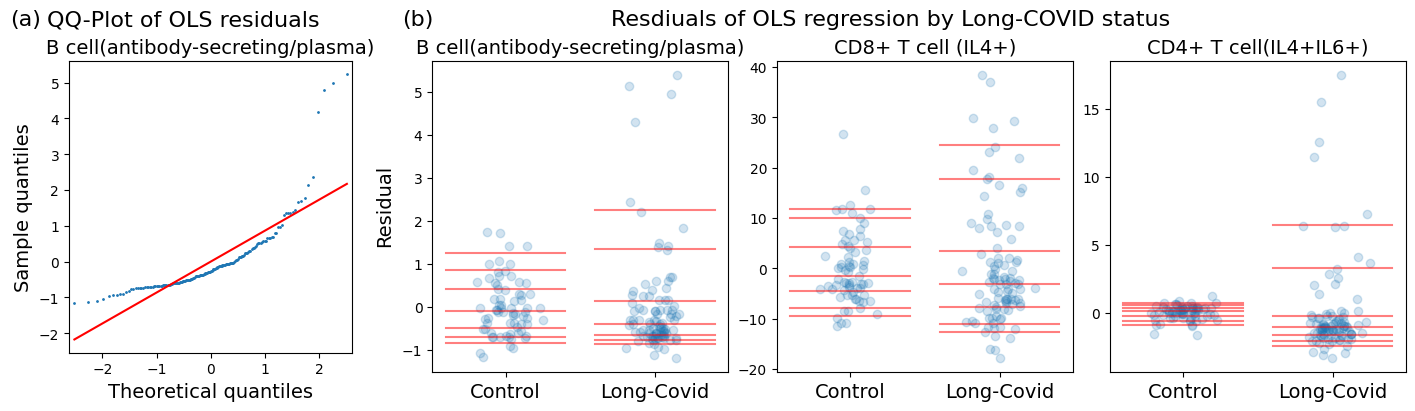

In [2]:

################################################
# Create the full figure parameters
################################################

full_fig = plt.figure(figsize = (14, 4), layout = "constrained")
(
    qq_fig,
    lc_fig
) = full_fig.subfigures(nrows = 1, ncols = 2, width_ratios = [1, 3])

################################################
# Create the QQ plot
################################################

def plot_qq(feature_name, ax):
    Y = df[feature_name].to_numpy()
    na_filter_idx = ~np.isnan(Y)
    Y = Y[na_filter_idx]
    X = X_unfiltered[na_filter_idx]
    Z = Z_unfiltered[na_filter_idx]

    X_full = np.concatenate([X, Z], axis = 1)

    pinv = np.linalg.pinv(X_full.T @ X_full) 
    resids = Y - X_full @ pinv @ X_full.T @ Y

    ax.set_title(feature_names_dict[feature_name], fontsize = 14)
    sm.qqplot(resids/np.std(resids), line = "r", ax = ax, markersize = 1)

    ax.set_ylabel("Sample quantiles", fontsize = 14)
    ax.set_xlabel("Theoretical quantiles", fontsize = 14)

fig = qq_fig

ax = fig.subplots()
fig.suptitle("QQ-Plot of OLS residuals", fontsize = 16)
plot_qq("ASCofB", ax)

# ax.set_xlim(-2, 5)
# ax.set_ylim(-2, 5)
# ax.set_aspect("equal")

fig.text(0.0, 0.95, "(a)", fontsize = 16)

################################################
# Create the LC plots
################################################

def plot_jittered_feature(feature_name, ax):
    Y = df[feature_name].to_numpy()
    na_filter_idx = ~np.isnan(Y)
    Y = Y[na_filter_idx]
    X = X_unfiltered[na_filter_idx]
    Z = Z_unfiltered[na_filter_idx]

    X_full = np.concatenate([X, Z], axis = 1)

    resids = Y - X_full @ np.linalg.pinv(X_full.T @ X_full) @ X_full.T @ Y

    idx_0 = (X == 0).reshape(-1)
    idx_1 = ~idx_0


    qs = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    width = 0.2
    LC_pos = 0.5

    ax.scatter(LC_pos * X.reshape(-1) + rng.normal(size = Y.shape[0], loc = 0, scale = 0.05), resids, alpha = 0.2)


    for q in qs:
        val = np.quantile(resids[idx_0], q)
        ax.plot([-width, width], [val, val], color = "red", alpha = 0.5)

        val = np.quantile(resids[idx_1], q)
        ax.plot([LC_pos - width, LC_pos + width], [val, val], color = "red", alpha = 0.5)


    ax.set_title(f"{feature_names_dict[feature_name]}", fontsize = 14)
    ax.set_xticks([0, LC_pos], ["Control", "Long-Covid"], fontsize = 14)

fig = lc_fig

interesting_examples = [
    "ASCofB", "IL4ofCD8", "IL4IL6DPofCD4"  # "CD4IFNypofCD4"
]

axs = fig.subplots(ncols = len(interesting_examples))
fig.supylabel("Residual", fontsize = 14)
fig.suptitle("Resdiuals of OLS regression by Long-COVID status", fontsize = 16)

# Two sided ScalePALMRT interesting examples
for i, feature_name in enumerate(interesting_examples):
    plot_jittered_feature(feature_name, axs[i])

fig.text(0.03, 0.95, "(b)", fontsize = 16)


full_fig.savefig(f"./images/MY-LC-intro-fig.eps", dpi = 800, bbox_inches = "tight")


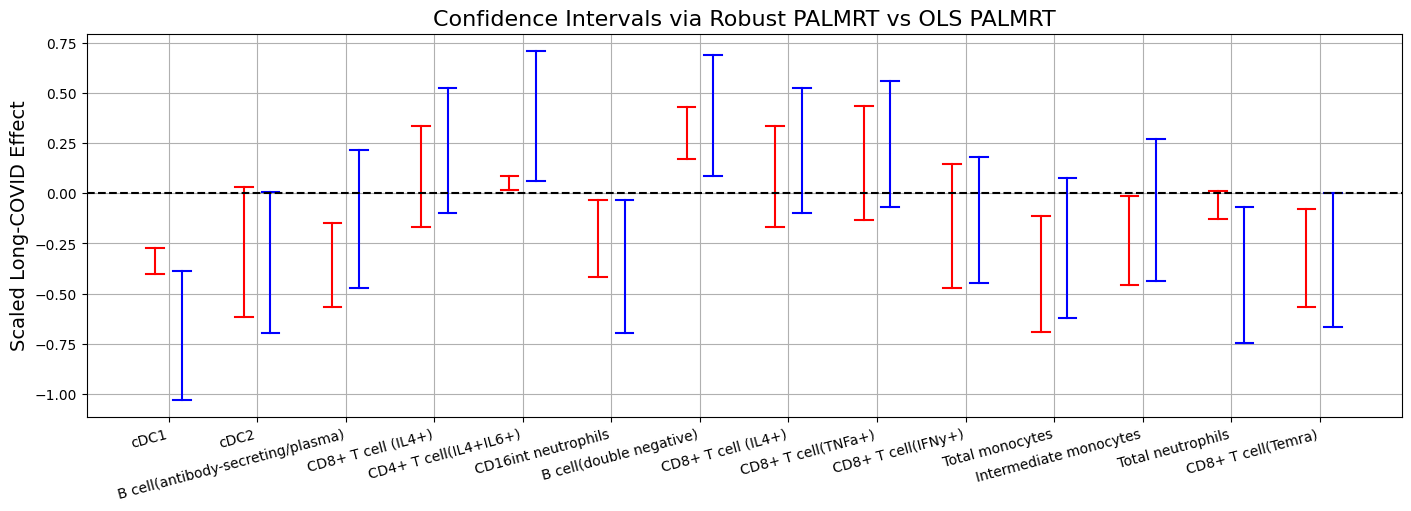

In [3]:

################################################
# Create the confidence interval plots
################################################

fig = plt.figure(figsize = (14, 5), layout = "constrained")
ax = fig.subplots()

features_to_plot = [
    "DC1ofLive",
    "DC2ofLive",
    "ASCofB",
    "IL4ofCD8",
    "IL4IL6DPofCD4",
    "CD16intNeutofLive",
    "DNofB",
    "IL4ofCD8",
    "CD8TNFapofCD8",
    "CD8IFNypofCD8",
    "TotalMonoofLive",
    "intMonoofLive",
    "TotalNeutofLive",
    "CD8TemraofCD8"
]
feature_names_clean = list(map(lambda l: feature_names_dict[l], features_to_plot))

horizontal_line_width = 0.2
def plot_confidence_interval(ax, index, lower, upper, point_estimate, color):
    left = index - horizontal_line_width / 2
    right = index + horizontal_line_width / 2

    ax.plot([index, index], [lower, upper], color)
    ax.plot([left, right], [upper, upper], color)
    ax.plot([left, right], [lower, lower], color)

ax.set_xticks(range(len(feature_names_clean)), feature_names_clean, rotation = 15, ha = "right")
ax.set_ylabel("Scaled Long-COVID Effect", fontsize = 14)
ax.set_title("Confidence Intervals via Robust PALMRT vs OLS PALMRT", fontsize = 16)
ax.grid()

for index, feature_name in enumerate(features_to_plot):
    sd_feature = np.sqrt(df[feature_name].var())

    plot_confidence_interval(
        ax,
        index - 0.15,
        intervals_info_df.loc[feature_name, "Huber-LowerBound"]/sd_feature,
        intervals_info_df.loc[feature_name, "Huber-UpperBound"]/sd_feature,
        intervals_info_df.loc[feature_name, "Huber-EstimatedBeta"]/sd_feature,
        "red"
    )
    plot_confidence_interval(
        ax,
        index + 0.15,
        intervals_info_df.loc[feature_name, "OLS-LowerBound"]/sd_feature,
        intervals_info_df.loc[feature_name, "OLS-UpperBound"]/sd_feature,
        intervals_info_df.loc[feature_name, "OLS-EstimatedBeta"]/sd_feature,
        "blue"
    )

ax.axhline(0., ls = "--", color = "black")

fig.savefig(f"./images/MY-LC-CIs.eps", dpi = 800, bbox_inches = "tight")
